# Train on differnet beta values and check if there is a phase transition. BUT Now switch on the hidden units and or visible unit fields to see if the transition happens at smaller beta values

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [102]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/16_PT_beta_with_fields')

In [ ]:
#import dill
#dill.load_session('./data_bruckner/data/notebookData/16_PT_beta_with_fields')

In [5]:
def beta_from_corrLength(corrLen):
    beta = np.tan((np.exp(-1./corrLen)))
    return beta

In [3]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
#corrLengths = np.linspace(0.01,20,10)
#beta = np.linspace(0.00001,1.2,10)
beta = np.array([10**-5,10**-4,10**-3,10**-2,10**-1,0.25,0.5,0.75,10**0,1.1])
print beta
#print corrLengths

[  1.00000000e-05   1.00000000e-04   1.00000000e-03   1.00000000e-02
   1.00000000e-01   2.50000000e-01   5.00000000e-01   7.50000000e-01
   1.00000000e+00   1.10000000e+00]


In [4]:
#Defining Parameters
Num_configs = 10000
#Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
N = np.zeros(len(beta)) + 100
Nstep = np.zeros(len(beta)) + 200
print N

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]


In [ ]:
%%capture captX

Xdata_big    = []
Xresults_big = []

XBM      = []
Xdata    = []
Xresults = []
XRBM     = []

Num_reps = 1

for j in range(Num_reps):
       
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        XBM.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        XBM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        XBM[i].layer.couplings[0,-1] += beta[i]
        XBM[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data
        Xdata.append(XBM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 5, hidden = 'Spin',zero_field = False))
        Xresults.append(XRBM[i].fit(Xdata[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W','FH','FV'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))
        
    Xdata_big.append(Xdata)
    Xresults_big.append(Xresults)
    
    XBM      = []
    Xdata    = []
    Xresults = []
    XRBM     = []

In [ ]:
# Top Eignvectors of the C_ij matrix:
def topEV(data):
    #Find the covariance matrix:
    covMAT = np.cov(data)
    Eval,Evec = np.linalg.eig(covMAT)
    return Evec(:,argmax(Eval))

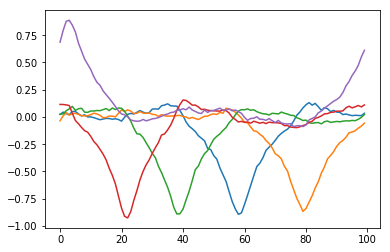

In [140]:
plt.plot(np.array(Xresults_big[0][-1]['W'])[-1,0,:])
plt.plot(np.array(Xresults_big[0][-1]['W'])[-1,1,:])
plt.plot(np.array(Xresults_big[0][-1]['W'])[-1,2,:])
plt.plot(np.array(Xresults_big[0][-1]['W'])[-1,3,:])
plt.plot(np.array(Xresults_big[0][-1]['W'])[-1,4,:])

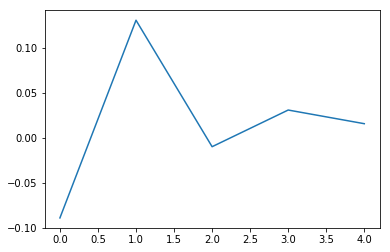

In [138]:
plt.plot(np.array(Xresults_big[-1][7]['FH'])[-1])
#plt.plot(np.array(Xresults_big[-1][7]['FH'])[-1])

### Calculate Sum of Weights, as the order parameter?

In [78]:
numHidden = 5
weights_sum = np.zeros([numHidden,len(beta)])
for j in range(numHidden):    
    for i in np.arange(len(beta)):
        weights_sum[j,i] = np.sum(np.array(Xresults_big[0][i]['W'])[-1,j,:])

In [92]:
print abs(weights_sum)

[[  0.35733547   0.15658377   0.42565593   0.02365709   0.3982371
    3.26752311   3.82498436   7.07337168   9.963758    11.06419483]
 [  0.43925471   0.58033288   0.97128146   0.64683097   1.6219856
    0.94696425   4.76531692   7.43429415   9.24636697  13.19585192]
 [  0.27665982   0.02920625   0.29679843   0.16046976   2.40645152
    1.28394702   4.43578636   7.3196446   12.06484759  11.96396068]
 [  0.10247708   0.32339383   0.28904592   0.29233715   2.53757848
    2.71057336   0.99343925   7.95821818  12.17039341  11.39055356]
 [  0.61951215   0.06471253   0.13687195   0.35597035   0.82002505
    3.59241533   7.80286815   6.65388264  10.39181754  13.90319259]]


Text(0.5,1,u'"Sum of Weights" order parameter with N/S = 0.01')

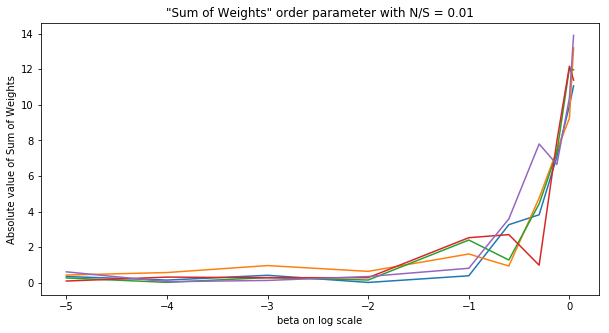

In [103]:
plt.figure(figsize=(10,5))
#plt.errorbar((beta),(np.mean(abs(weights_sum),axis=0)),yerr=np.std(abs(weights_sum),axis=0),xlolims=0,fmt='o',ecolor='g')
plt.plot(np.log10(beta),abs(weights_sum)[0,:])
plt.plot(np.log10(beta),abs(weights_sum)[1,:])
plt.plot(np.log10(beta),abs(weights_sum)[2,:])
plt.plot(np.log10(beta),abs(weights_sum)[3,:])
plt.plot(np.log10(beta),abs(weights_sum)[4,:])
#plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Sum of Weights')
plt.title('"Sum of Weights" order parameter with N/S = 0.01')

## Calculate Overlap(dot product) of the weights with the top Eigenvector - is that the order parameter?

In [94]:
# Top Eignvectors of the C_ij matrix:
def topEV(data,method='Covariance'):
    if method is 'Covariance':
        #Find the covariance matrix:
        covMAT = np.cov(data)
    elif method is 'Correlation':
        covMAT = np.corrcoef(data)
    Eval,Evec = np.linalg.eig(covMAT)
    return Evec[:,np.argmax(Eval)],np.max(Eval)

In [96]:
weights_overlap = np.zeros([Num_reps,len(beta)])
mat_topEval_corr = np.zeros([Num_reps,len(beta)])
mat_topEV_corr = np.zeros([Num_reps,len(beta),N[0]])

for j in range(Num_reps):    
    for i in np.arange(len(beta)):
        mat_topEV_corr[j,i,:],mat_topEval_corr[j,i] = topEV(Xdata_big[j][i].T,method='Correlation')
        weights_overlap[j,i] = np.dot(mat_topEV_corr[j,i,:],(np.array(Xresults_big[j][i]['W'])[-1,0,:]))

Text(0.5,1,u'"Overlap of Top Eignevector with Weights" order parameter with N/S = 0.01')

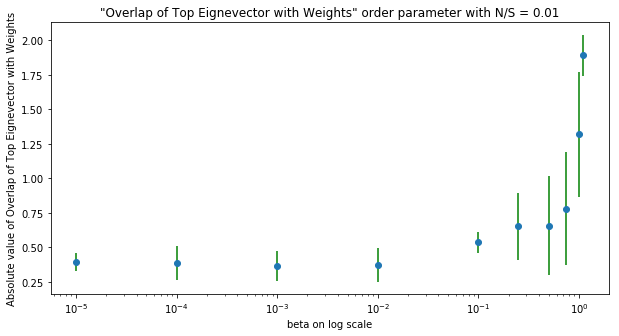

In [101]:
plt.figure(figsize=(10,5))
plt.errorbar((beta),(np.mean(abs(weights_overlap),axis=0)),yerr=np.std(abs(weights_overlap),axis=0),xlolims=0,fmt='o',ecolor='g')
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Overlap of Top Eignevector with Weights')
plt.title('"Overlap of Top Eignevector with Weights" order parameter with N/S = 0.01')

## Long time behaviour of two hidden units:

In [ ]:
%%capture capt1
#Supress the output of the cell and save it to capt1

N = 100
beta = 1.
Num_configs = 100000

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Spin')

#Define Couplings
BM.layer.couplings =  beta* (np.eye(N=N,k=1) + np.eye(N=N,k=-1) )
BM.layer.couplings[0,-1] += beta
BM.layer.couplings[-1,0] += beta

data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=400) # N steps.

#Train the model
RBM = rbm.RBM(visible = 'Spin', n_v=N, n_h = 2, hidden = 'Spin',zero_field = True)
results = RBM.fit(data,n_iter=10000,verbose=0,learning_rate = 0.05,record=['W'],record_interval=2500,batch_size=20,N_MC= 20, lr_decay=False,batch_norm=False);

In [14]:
peakCentre = np.zeros([np.shape(np.array(results['W']))[0],np.shape(np.array(results['W']))[1]])
peakCentre = np.argmax(abs(np.array(results['W'])),axis=2)

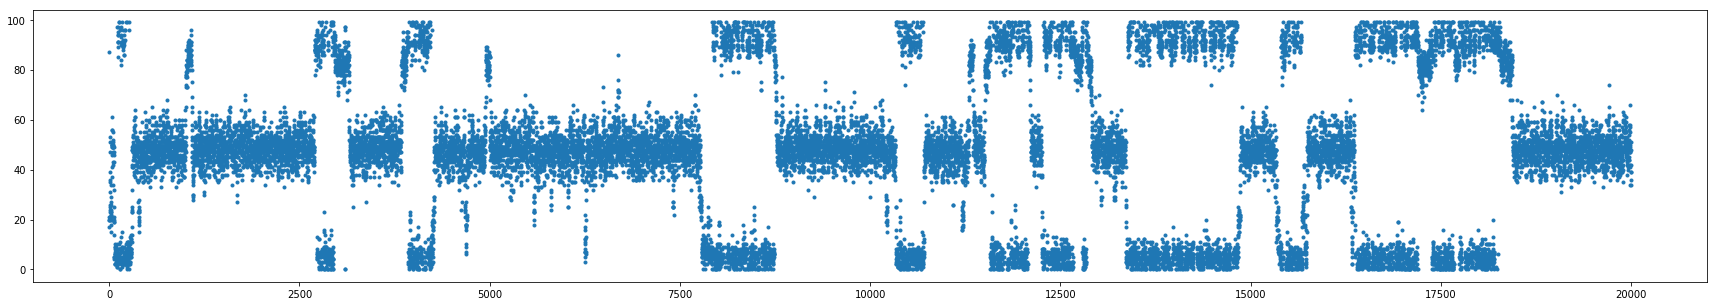

In [27]:
plt.figure(figsize=(30,5))
plt.plot(peakCentre[:,0],'.')

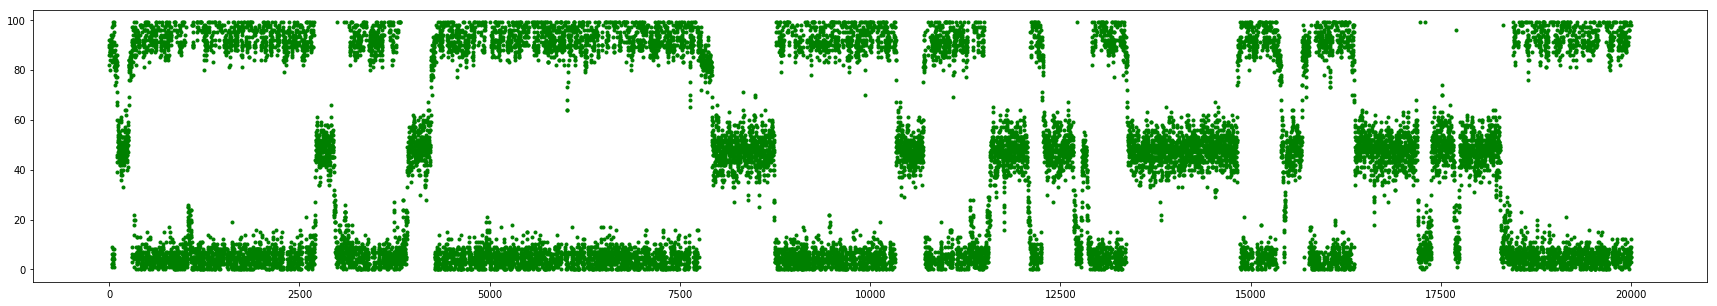

In [32]:
plt.figure(figsize=(30,5))
plt.plot(peakCentre[:,1],'g.')

In [ ]:
RBM.likelihood()

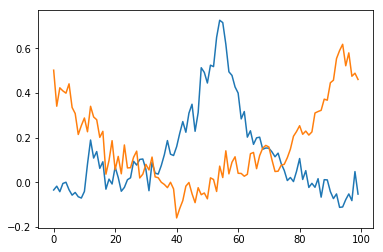

In [35]:
plt.plot(np.array(results['W'])[-4000,0,])
plt.plot(np.array(results['W'])[-4000,1,])